In [2]:
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [3]:
batch_size = 32
epochs = 50
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 3
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
def model_type(depth,version):
  model_type = 'ResNet%dv%d' % (depth, version)
  print(model_type)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 6s 0us/step


In [5]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    return lr

In [6]:
def resnet_layer(inputs,num_filters=16,kernel_size=3,strides=1,activation='relu',batch_normalization=True,conv_first=True):
    conv = Conv2D(num_filters,kernel_size=kernel_size,strides=strides,padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [7]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,num_filters=num_filters,strides=strides)
            y = resnet_layer(inputs=y,num_filters=num_filters,activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                x = resnet_layer(inputs=x,num_filters=num_filters,kernel_size=1,strides=strides,activation=None,batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,activation='softmax',kernel_initializer='he_normal')(y)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
def resnet_v2(input_shape, depth, num_classes=10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,num_filters=num_filters_in,conv_first=True)
    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample
            # bottleneck residual unit
            y = resnet_layer(inputs=x,num_filters=num_filters_in,kernel_size=1,strides=strides,activation=activation,batch_normalization=batch_normalization,conv_first=False)
            y = resnet_layer(inputs=y,num_filters=num_filters_in,conv_first=False)
            y = resnet_layer(inputs=y,num_filters=num_filters_out,kernel_size=1,conv_first=False)
            if res_block == 0:
                x = resnet_layer(inputs=x,num_filters=num_filters_out,kernel_size=1,strides=strides,activation=None,batch_normalization=False)
            x = keras.layers.add([x, y])
        num_filters_in = num_filters_out
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,activation='softmax',kernel_initializer='he_normal')(y)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=lr_schedule(0)),metrics=['accuracy'])
model.summary()
print(model_type)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(x_train, y_train, batch_size=256)
val_batches = gen.flow(x_test, y_test, batch_size=256)
history1 = model.fit_generator(batches, steps_per_epoch=48000//256, epochs=50,validation_data=val_batches, validation_steps=12000//256, use_multiprocessing=True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
187/187 [==============================] - 28s 150ms/step - loss: 1.7443 - accuracy: 0.4269 - val_loss: 2.4343 - val_accuracy: 0.2939
Epoch 2/50
187/187 [==============================] - 29s 157ms/step - loss: 1.3850 - accuracy: 0.5572 - val_loss: 1.7731 - val_accuracy: 0.4359
Epoch 3/50
187/187 [==============================] - 29s 157ms/step - loss: 1.2127 - accuracy: 0.6225 - val_loss: 1.3920 - val_accuracy: 0.5570
Epoch 4/50
187/187 [==============================] - 29s 156ms/step - loss: 1.0800 - accuracy: 0.6702 - val_loss: 1.2948 - val_accuracy: 0.5970
Epoch 5/50
187/187 [==============================] - 29s 157ms/step - loss: 0.9837 - accuracy: 0.7062 - val_loss: 1.3514 - val_accuracy: 0.5819
Epoch 6/50
187/187 [==============================] - 29s 158ms/step - loss: 0.9110 - accuracy: 0.7307 - val_loss: 1.3072 - val_accuracy: 0.6030
Epoch 7/50
187/187 [==============================] - 

Resnet20V1
Test loss: 0.831516683101654
Test accuracy: 0.8134999871253967


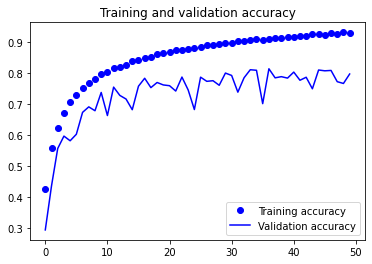

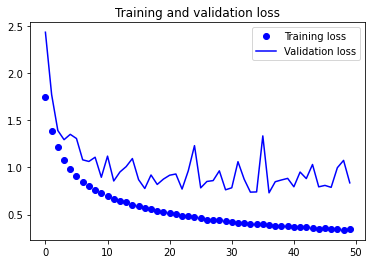

In [12]:
score1 = model.evaluate(x_test, y_test, verbose=0)
print('Resnet20V1')
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
version=2
model1 = resnet_v2(input_shape=input_shape, depth=depth)
model1.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=lr_schedule(0)),metrics=['accuracy'])
model1.summary()
model_type(depth,version)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 16)   0           batch_normalization_19[0][0]     
_______________________________________________________________________________________

In [11]:
gen1 = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,height_shift_range=0.08, zoom_range=0.08)
batches1 = gen1.flow(x_train, y_train, batch_size=256)
val_batches1 = gen1.flow(x_test, y_test, batch_size=256)
history2 = model1.fit_generator(batches1, steps_per_epoch=48000//256, epochs=50,validation_data=val_batches1, validation_steps=12000//256, use_multiprocessing=True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
187/187 [==============================] - 33s 179ms/step - loss: 1.9716 - accuracy: 0.4288 - val_loss: 2.4728 - val_accuracy: 0.2777
Epoch 2/50
187/187 [==============================] - 35s 186ms/step - loss: 1.5864 - accuracy: 0.5547 - val_loss: 2.0556 - val_accuracy: 0.3988
Epoch 3/50
187/187 [==============================] - 35s 185ms/step - loss: 1.3901 - accuracy: 0.6192 - val_loss: 1.7040 - val_accuracy: 0.5171
Epoch 4/50
187/187 [==============================] - 35s 186ms/step - loss: 1.2642 - accuracy: 0.6587 - val_loss: 1.4464 - val_accuracy: 0.6108
Epoch 5/50
187/187 [==============================] - 35s 185ms/step - loss: 1.1675 - accuracy: 0.6905 - val_loss: 1.4250 - val_accuracy: 0.5934
Epoch 6/50
187/187 [==============================] - 35s 185ms/step - loss: 1.0848 - accuracy: 0.7195 - val_loss: 1.2472 - val_accuracy: 0.6639
Epoch 7/50
187/187 [==============================] - 

Resnet20V2
Test loss: 0.7562071681022644
Test accuracy: 0.8331000208854675


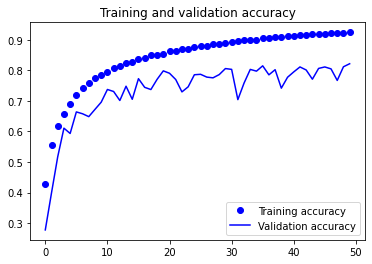

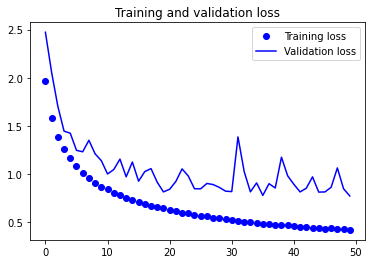

In [12]:
score2 = model1.evaluate(x_test, y_test, verbose=0)
print('Resnet20V2')
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()